In [49]:
import os
import pandas as pd
data = os.path.join("Data", "SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv") 
sensor_loc = os.path.join("Data", "sensor-location.csv") 
df_data = pd.read_csv(data)
df_sensors = pd.read_csv(sensor_loc, sep =  ";")

base_names = set()
for col in df_data.columns:
    if "_" in col:
        base = "_".join(col.split("_")[:-1])
        base_names.add(base)

time_cols = ["timestamp", "hour", "minute", "day", "month", "weekday", "is_weekend"]
time_cols = [c for c in time_cols if c in df_data.columns]  # only keep existing ones
df_combined = df_data[time_cols].copy()

#here we combine the data
for base in base_names:
    related_cols = [c for c in df_data.columns if c.startswith(base + "_")]
    if len(related_cols) >1: 
        df_combined[base] = df_data[related_cols].sum(axis=1)   



In [ ]:
#effectieve breedte bruikbaar maken om mee te rekenen
df_sensors["Effectieve breedte"] = (
    df_sensors["Effectieve breedte"]
    .astype(str)
    .str.replace(",", ".")
    .astype(float)
)

#directional flow
directional_cols = [c for c in df_data.columns if "_" in c]
id_cols = ["timestamp", "hour", "minute", "day", "month", "weekday", "is_weekend"]

df_long = df_data.melt(
    id_vars=id_cols,
    value_vars=directional_cols,
    var_name="sensor_direction",
    value_name="count"
)

df_long["Objectummer"] = df_long["sensor_direction"].str.rsplit("_", n=1).str[0]


df_long = df_long.merge(
    df_sensors[["Objectummer", "Effectieve breedte"]],
    on="Objectummer",
    how="left"
)

df_long["flow"] = df_long["count"] / (3 * df_long["Effectieve breedte"]) # flow = count /( 3 (min)  * effective witdh field)

df_long_sorted = df_long.sort_values(by="flow", ascending=False)


#combined flow
df_combined_long = (
    df_long
    .groupby(["timestamp", "Objectummer"], as_index=False)
    .agg({"flow": "sum"})
)

df_combined_long_sorted = df_combined_long.sort_values(by="flow", ascending=False)


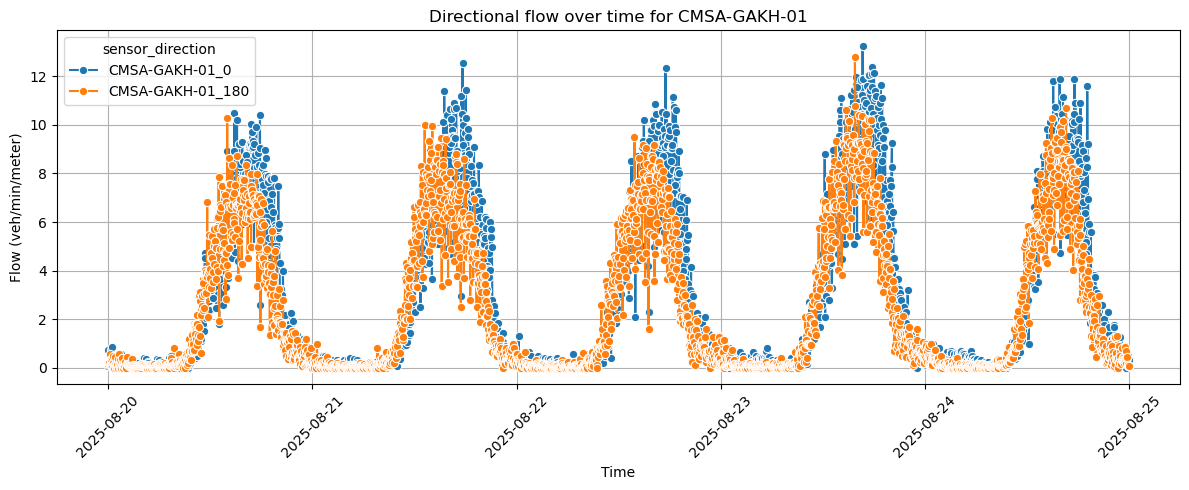

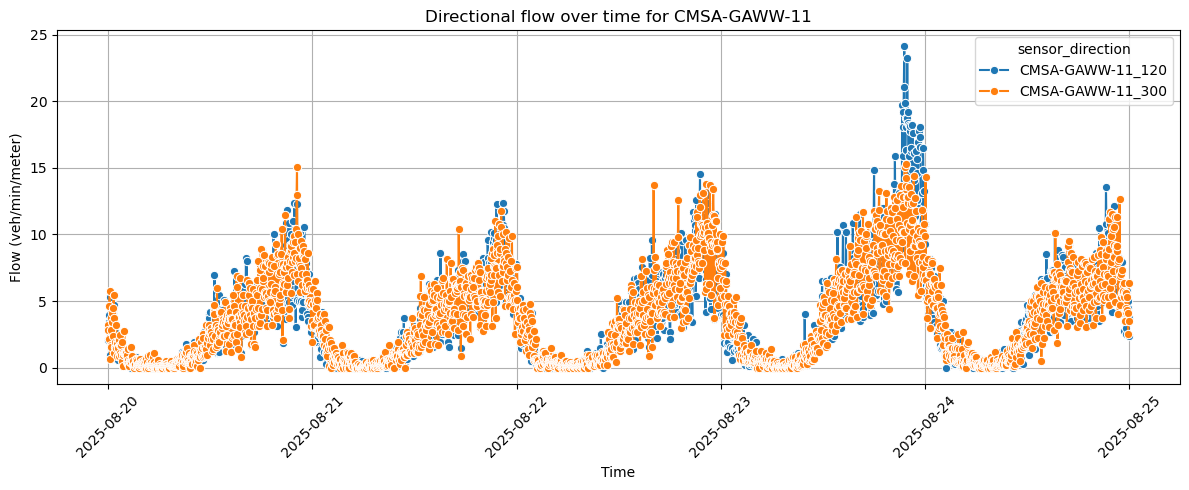

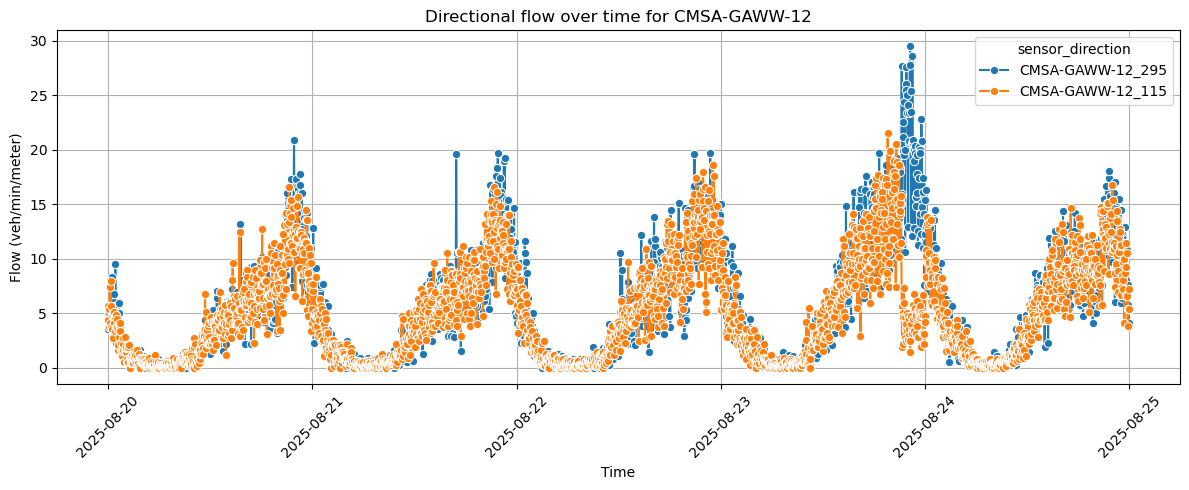

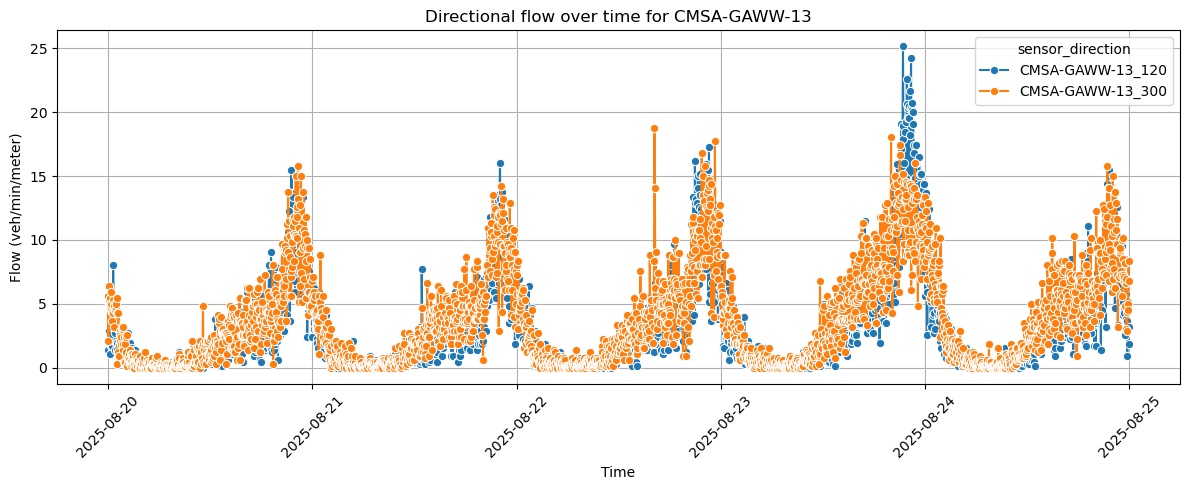

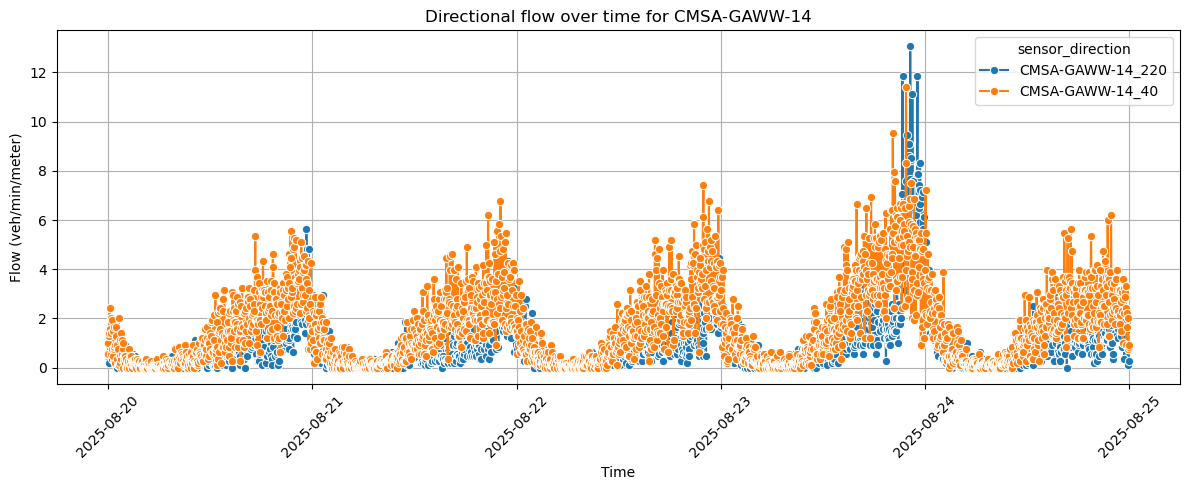

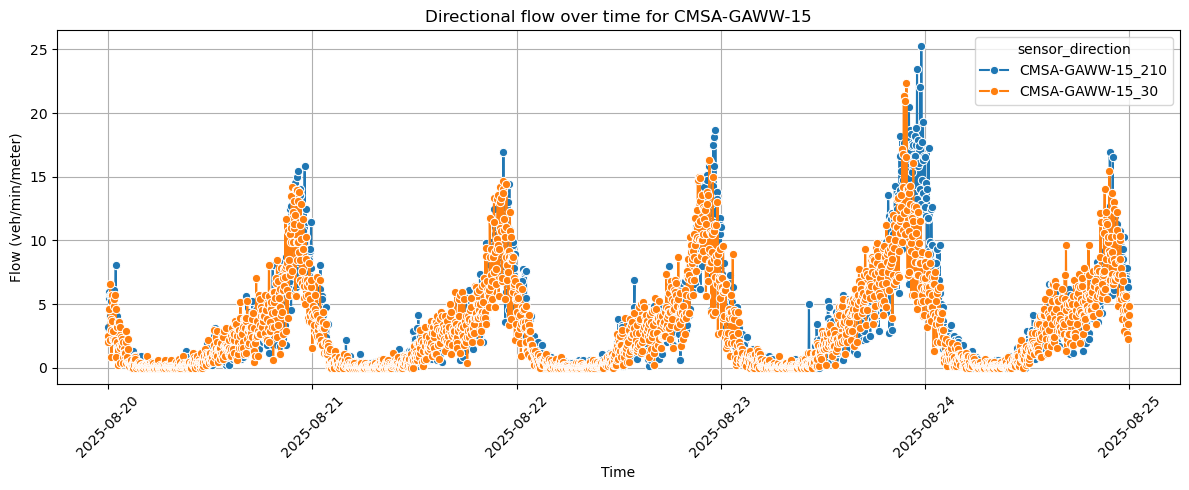

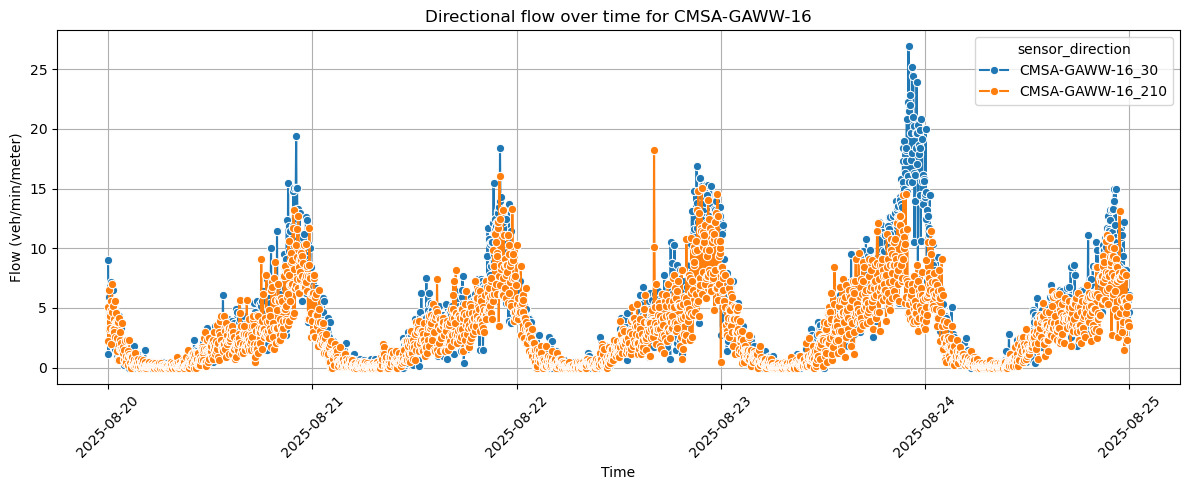

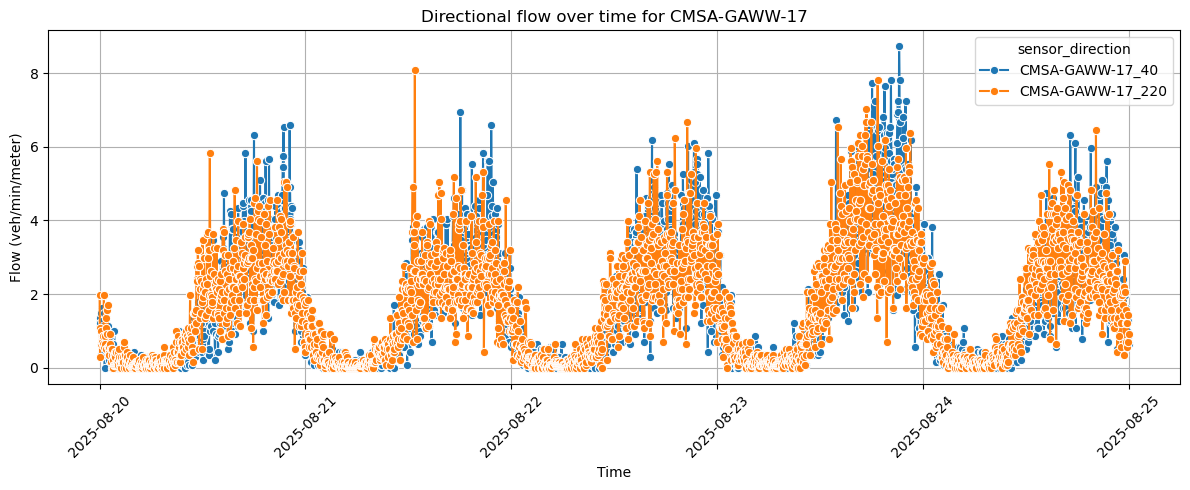

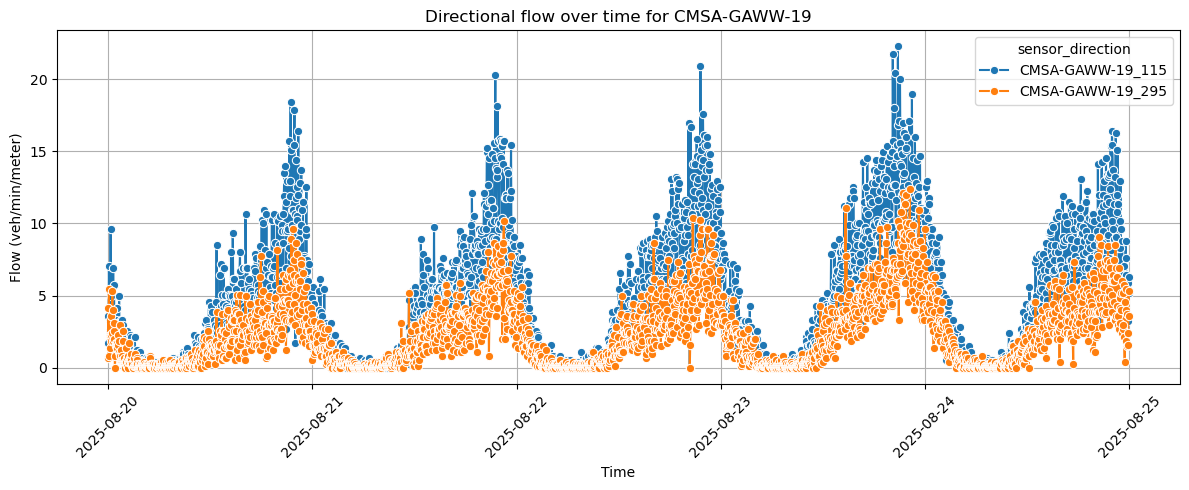

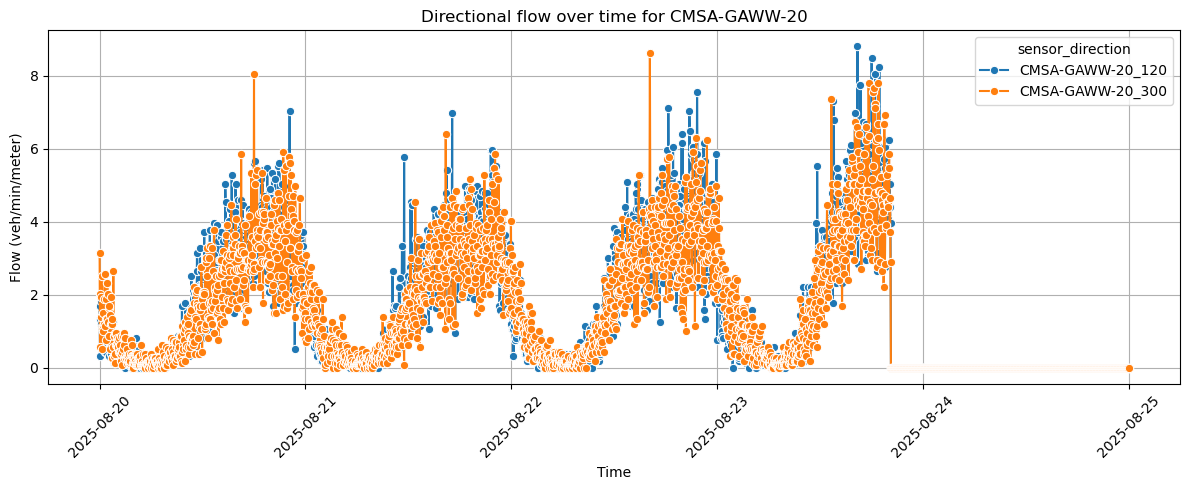

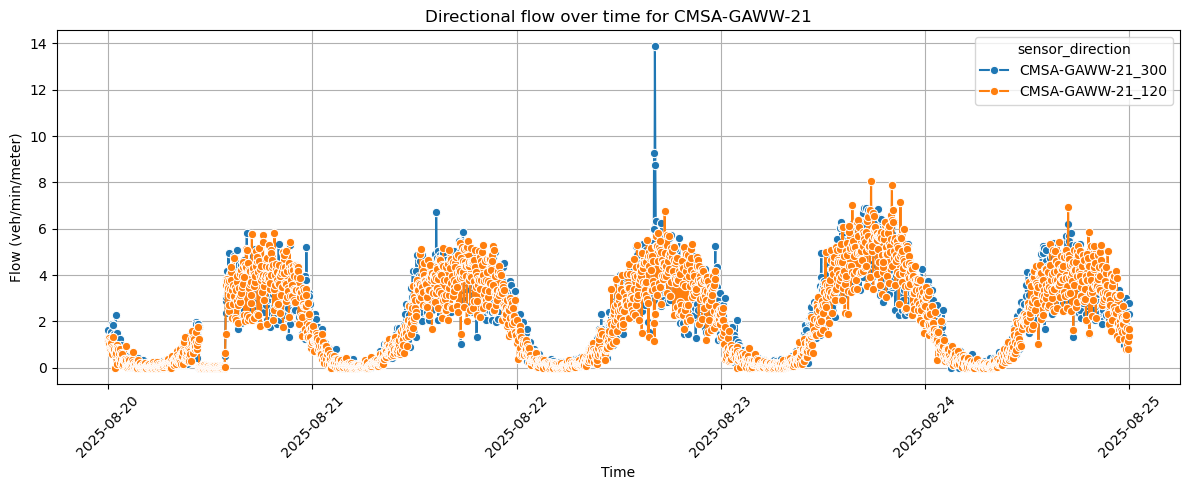

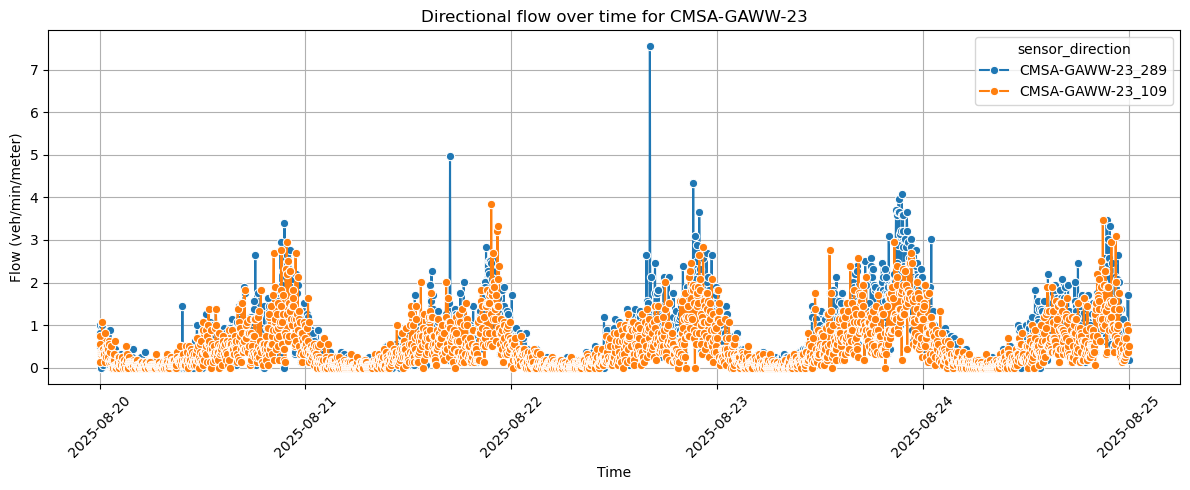

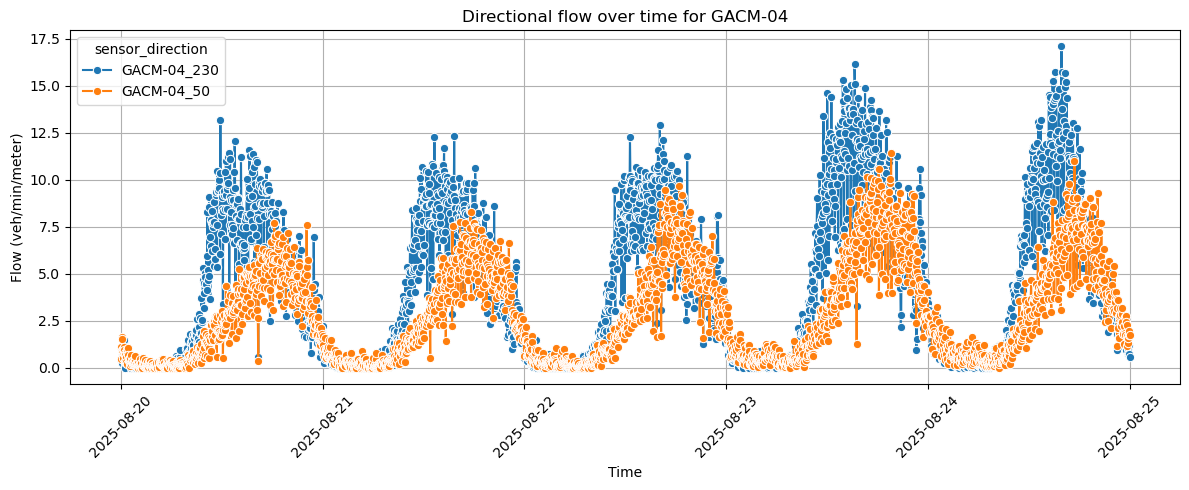

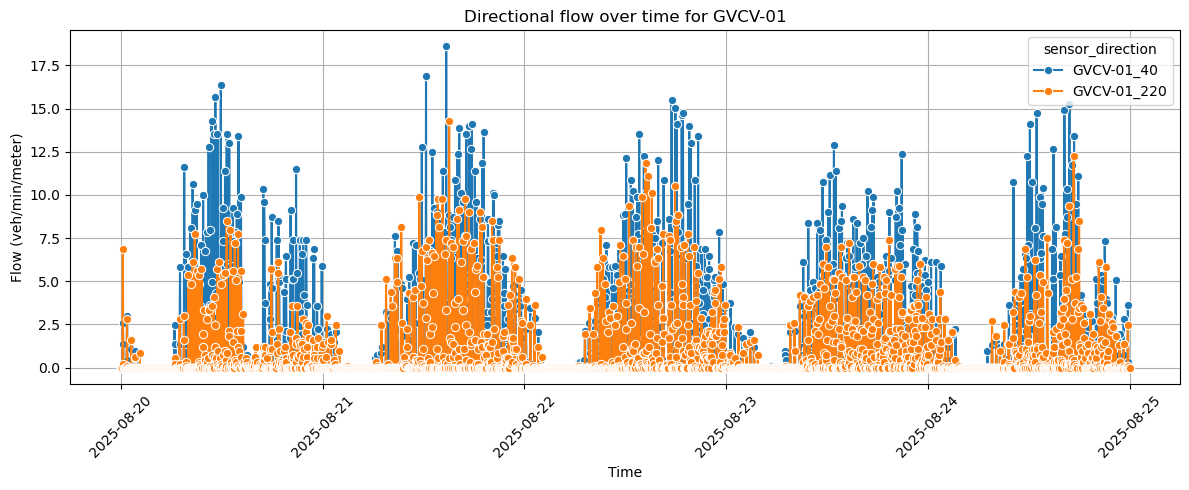

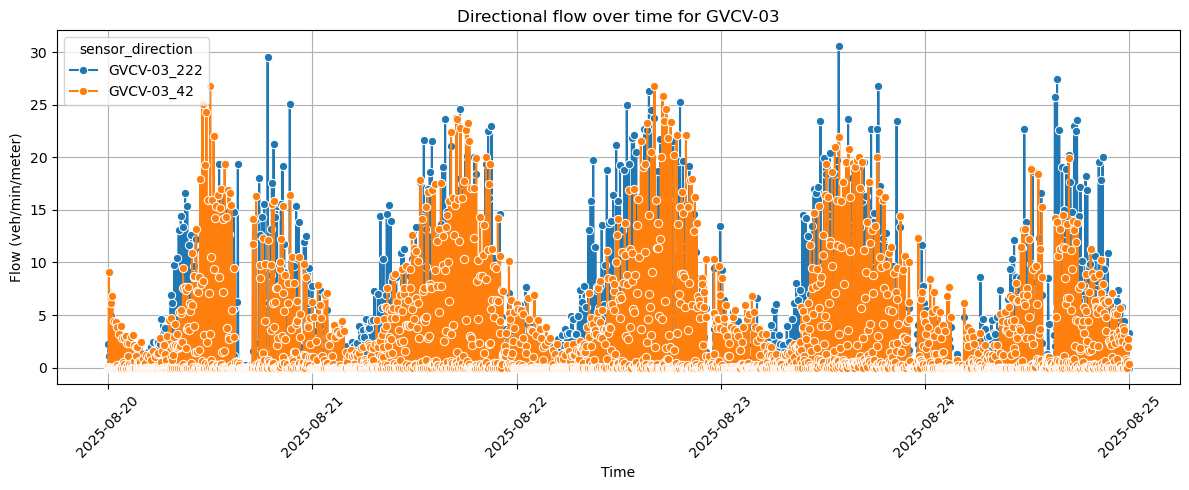

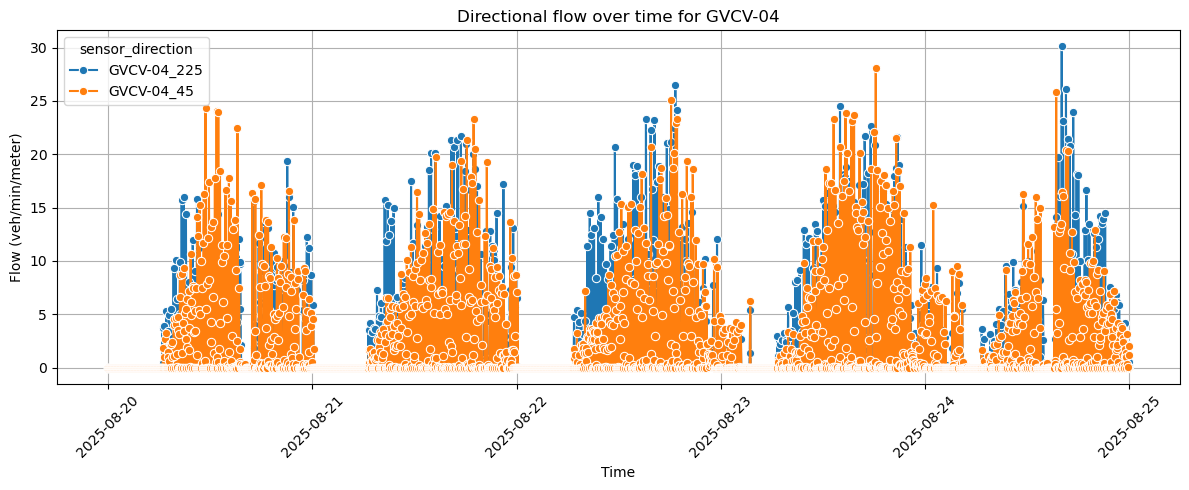

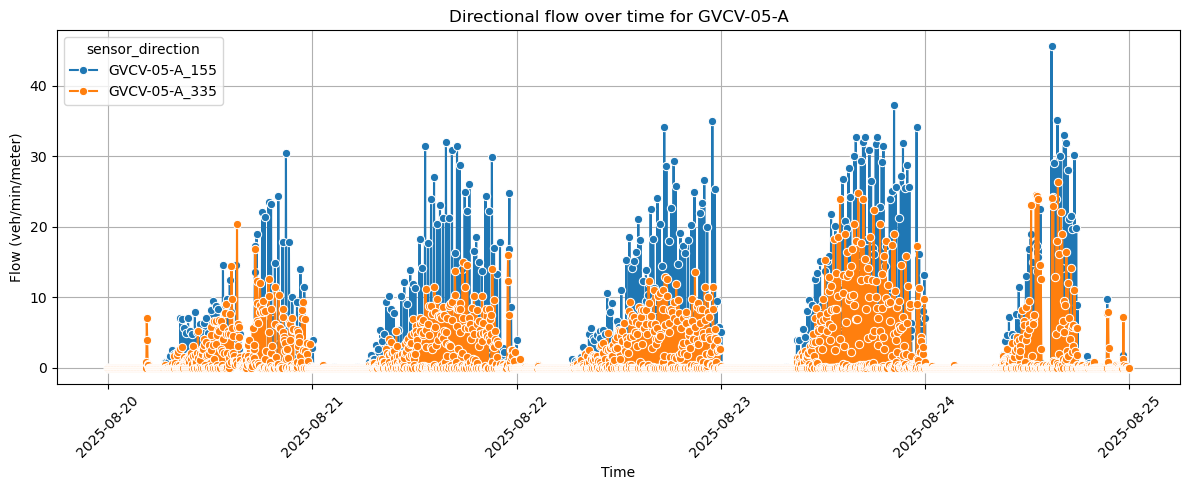

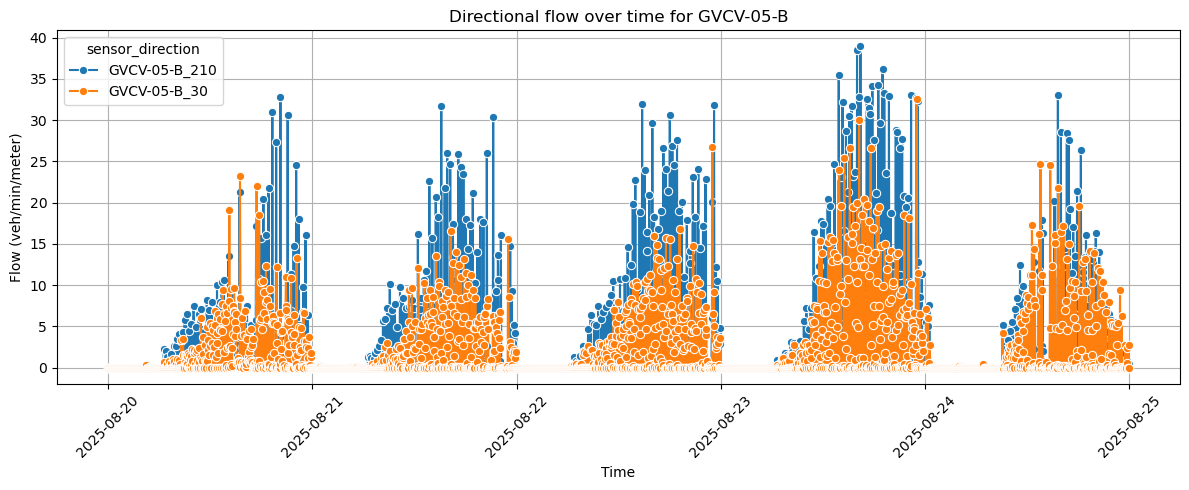

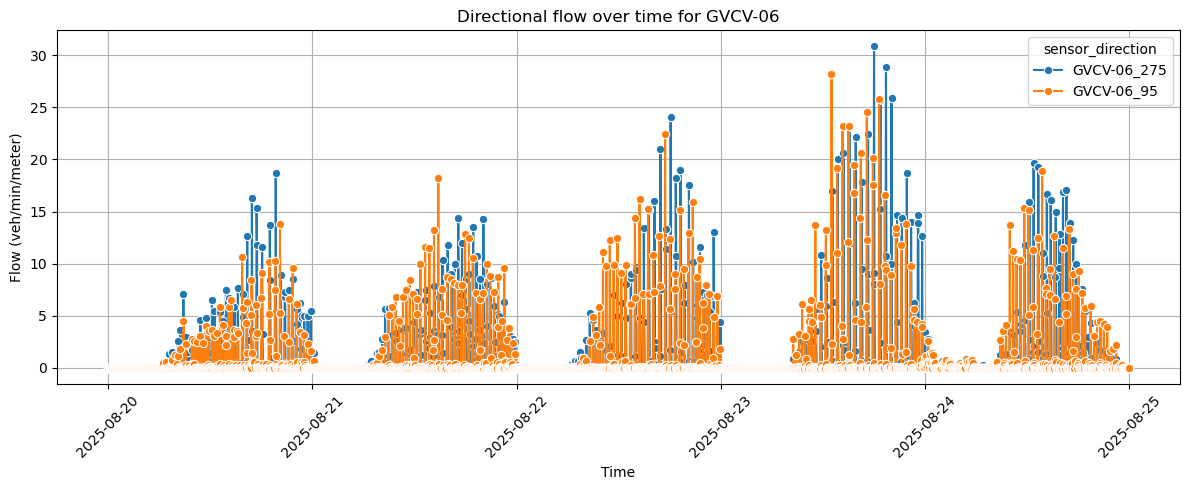

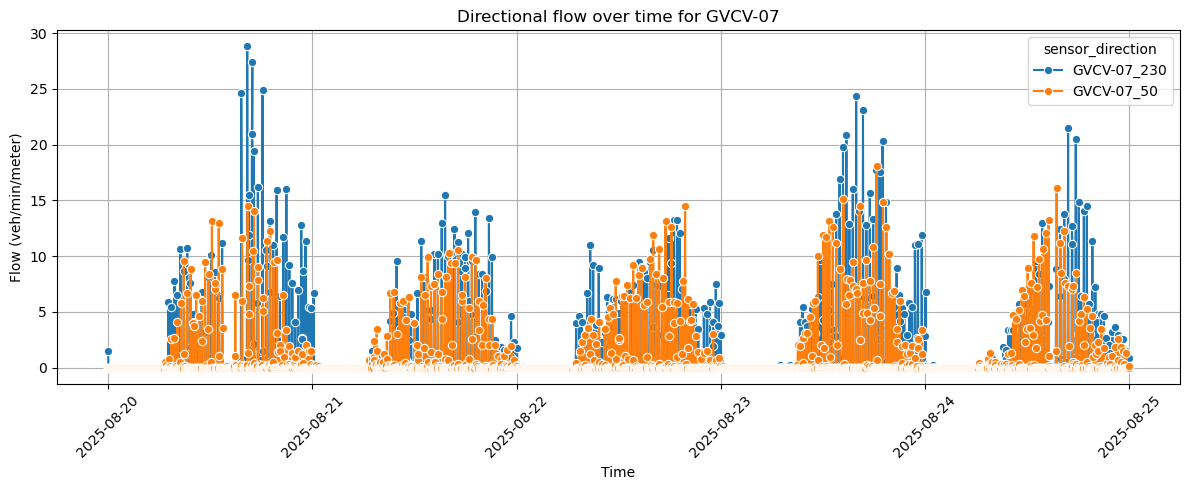

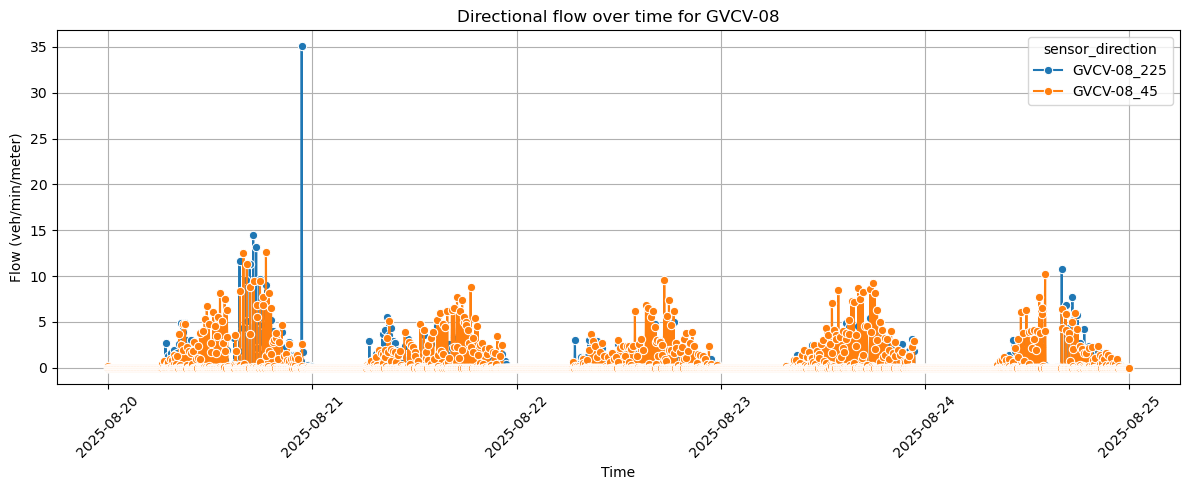

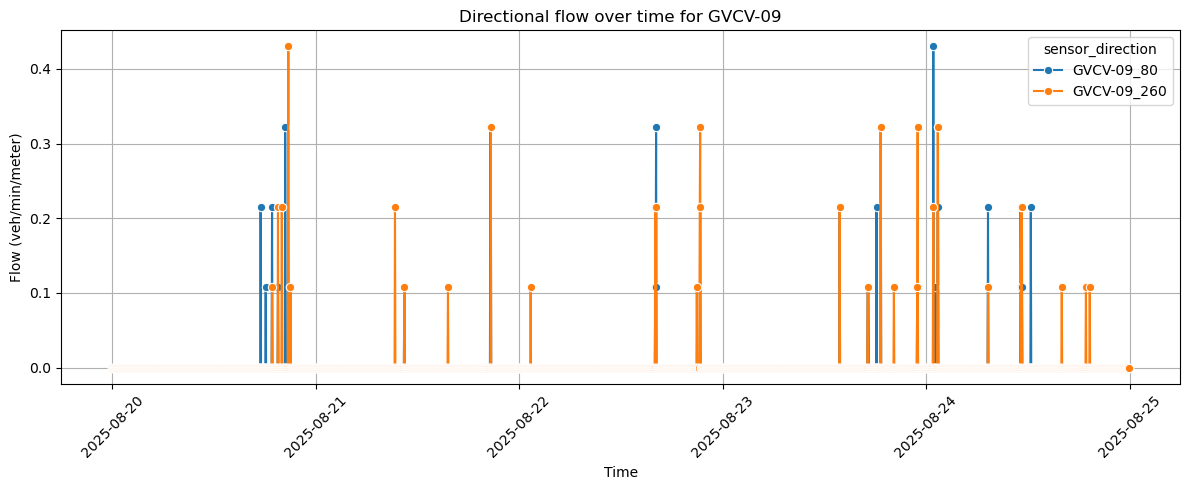

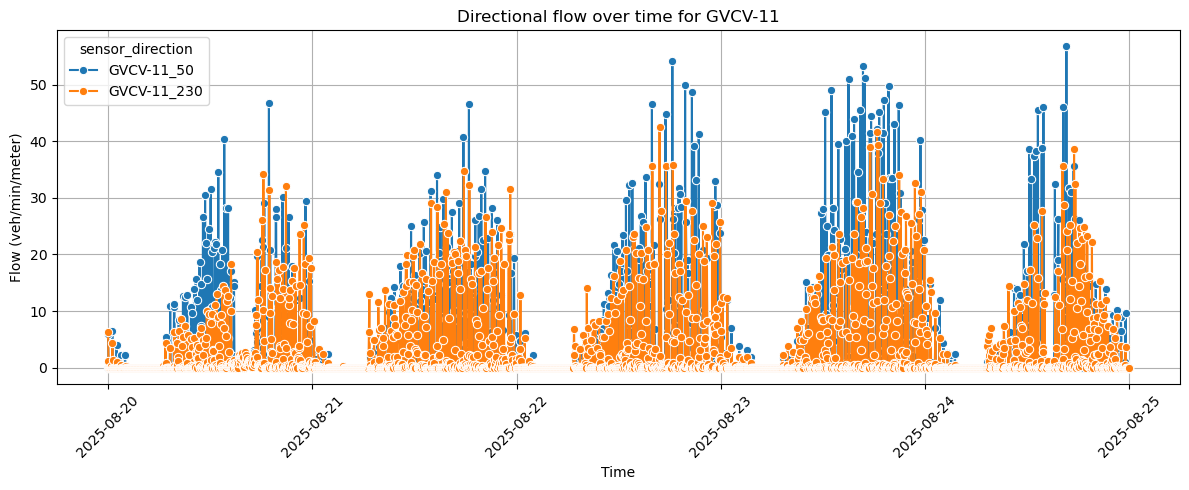

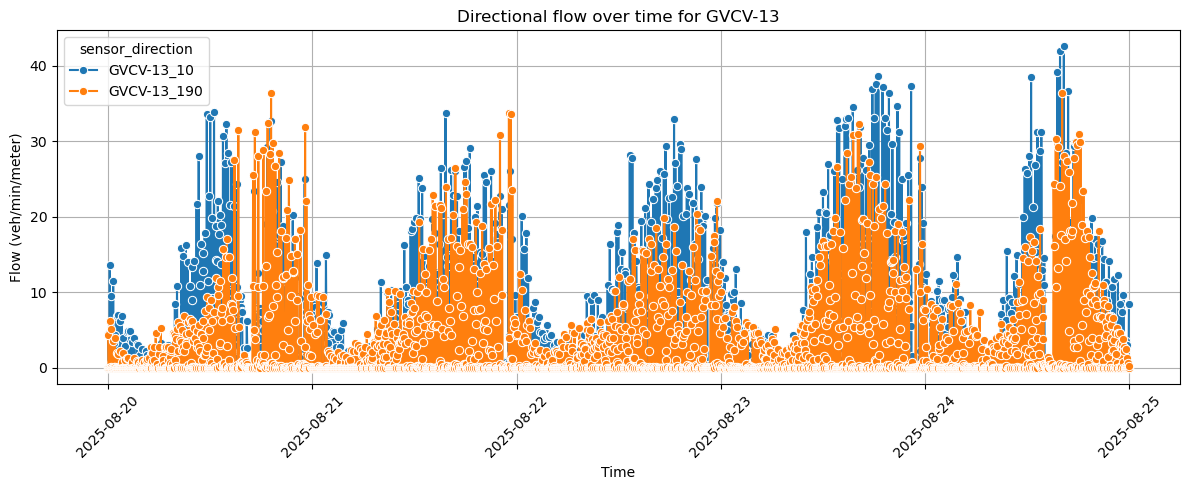

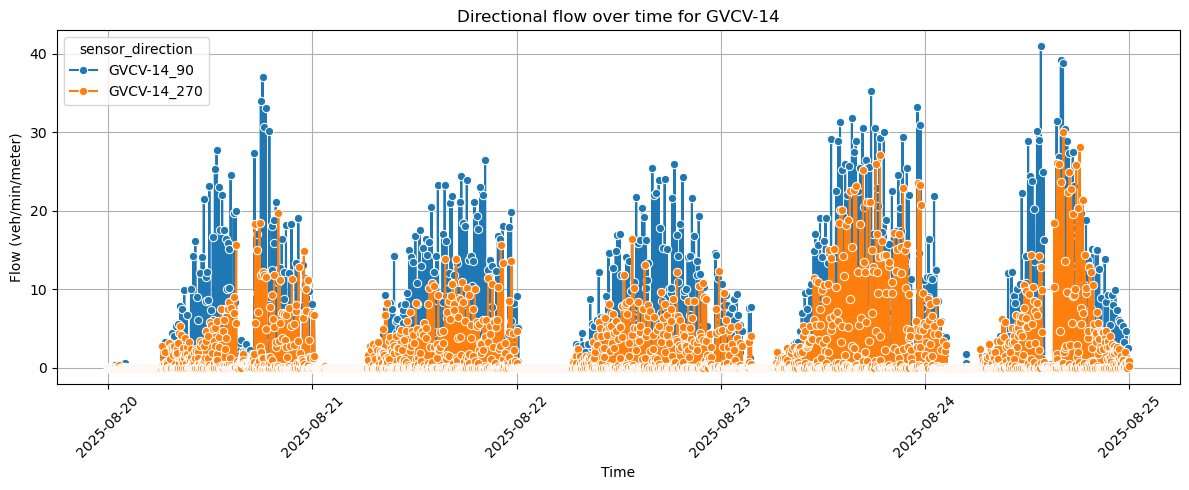

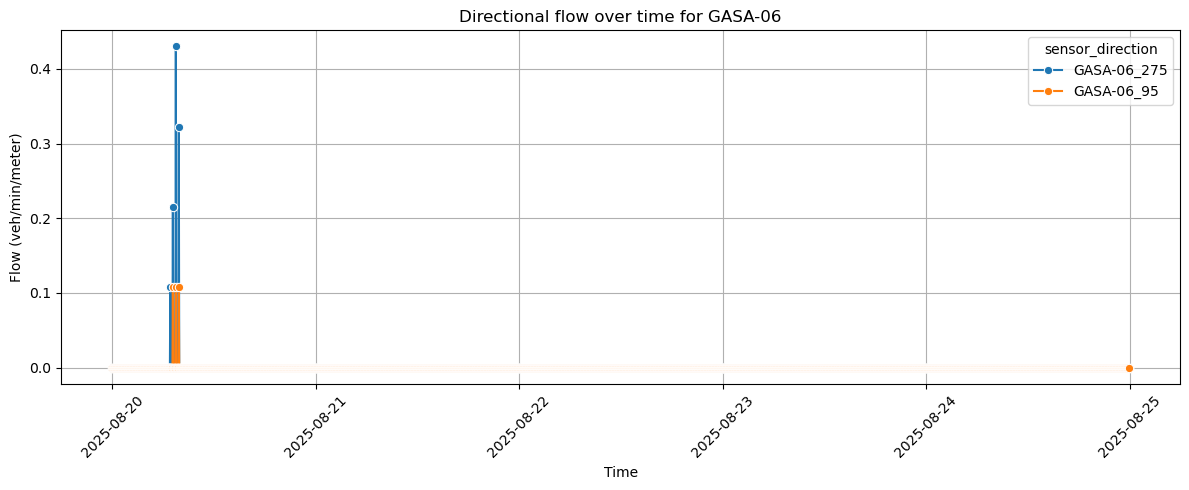

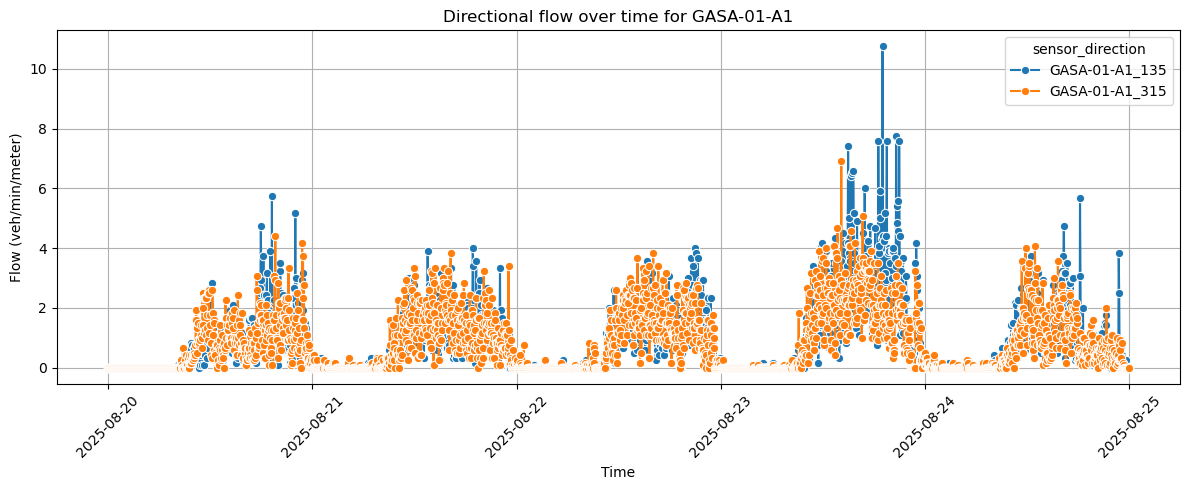

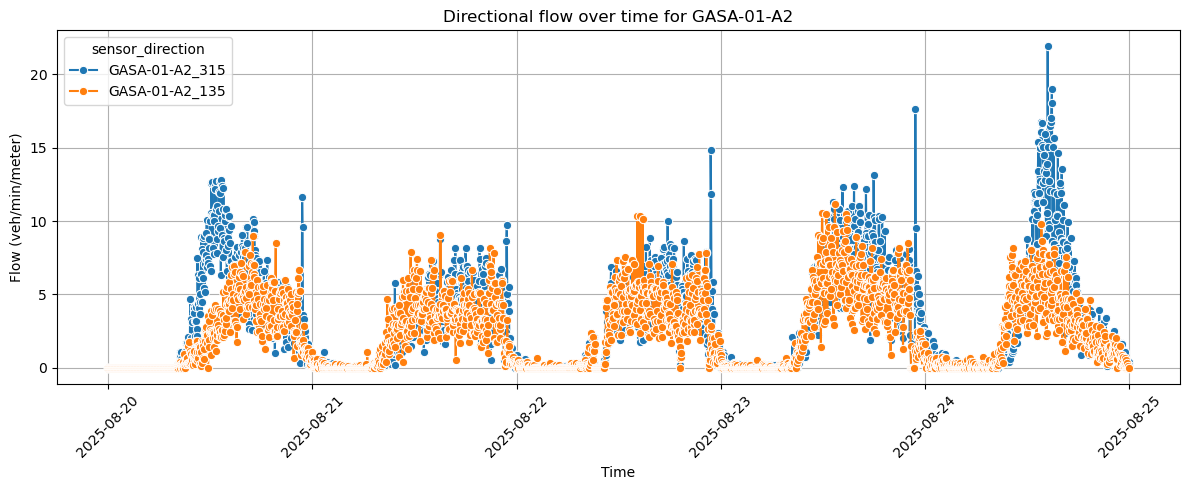

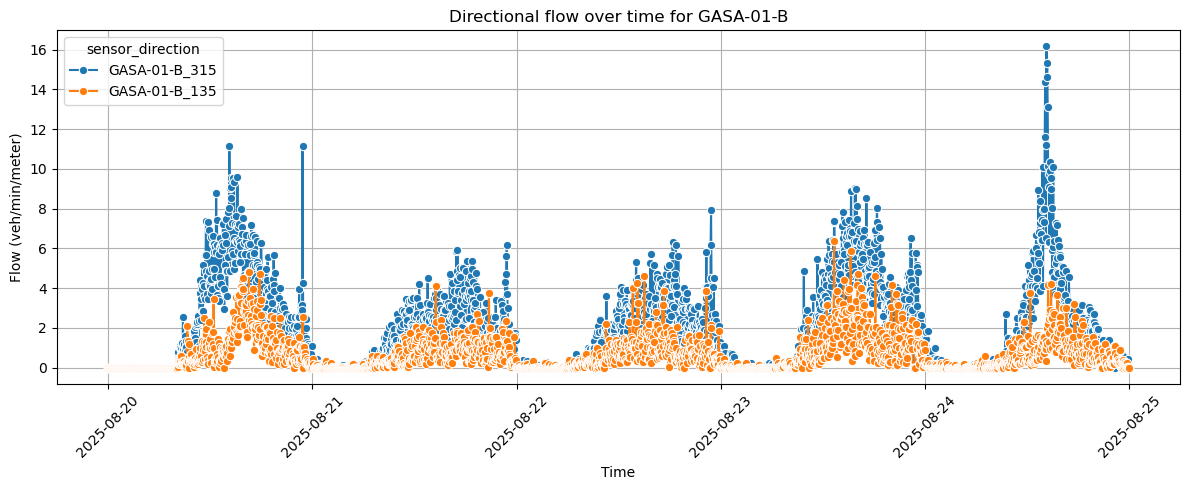

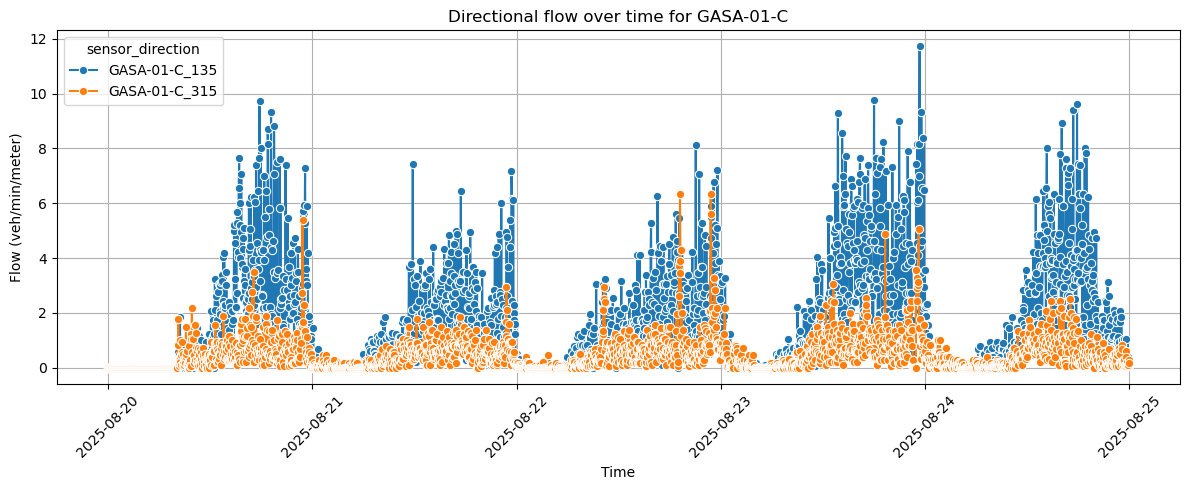

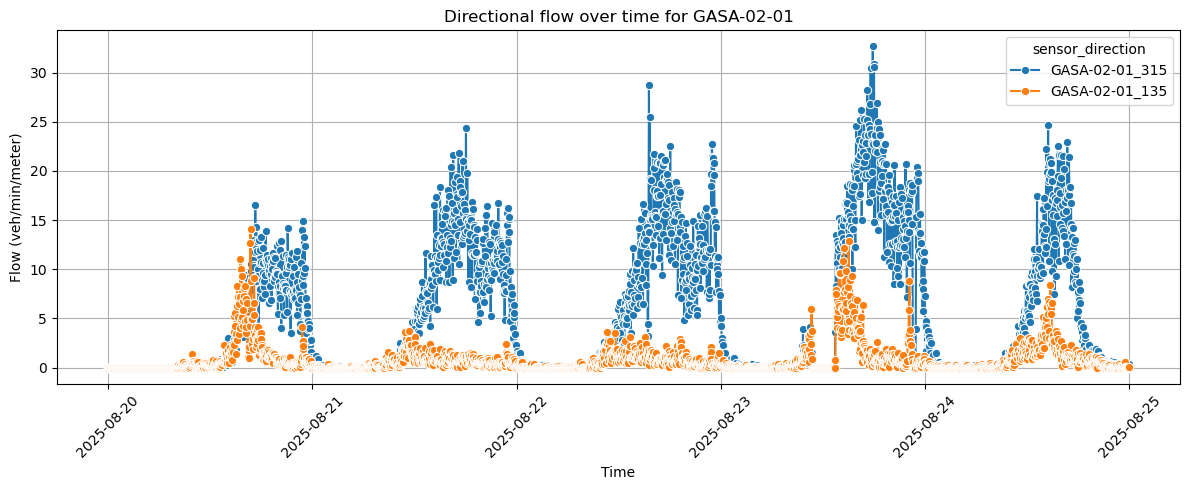

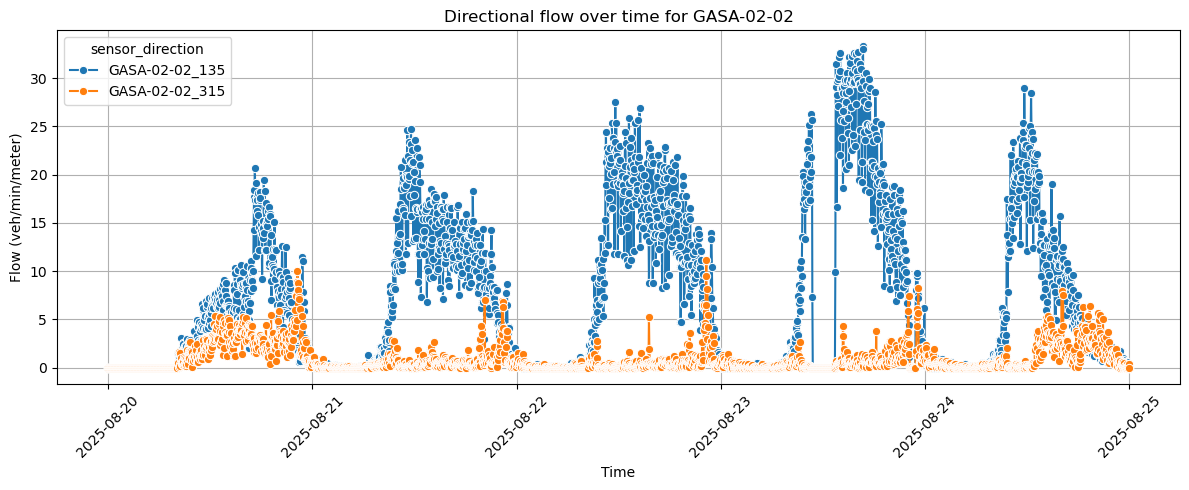

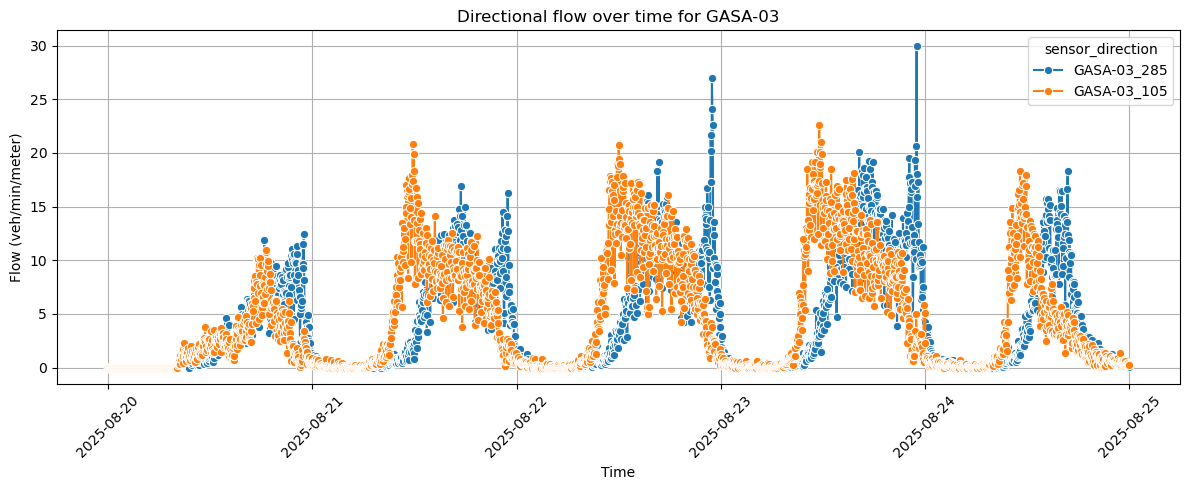

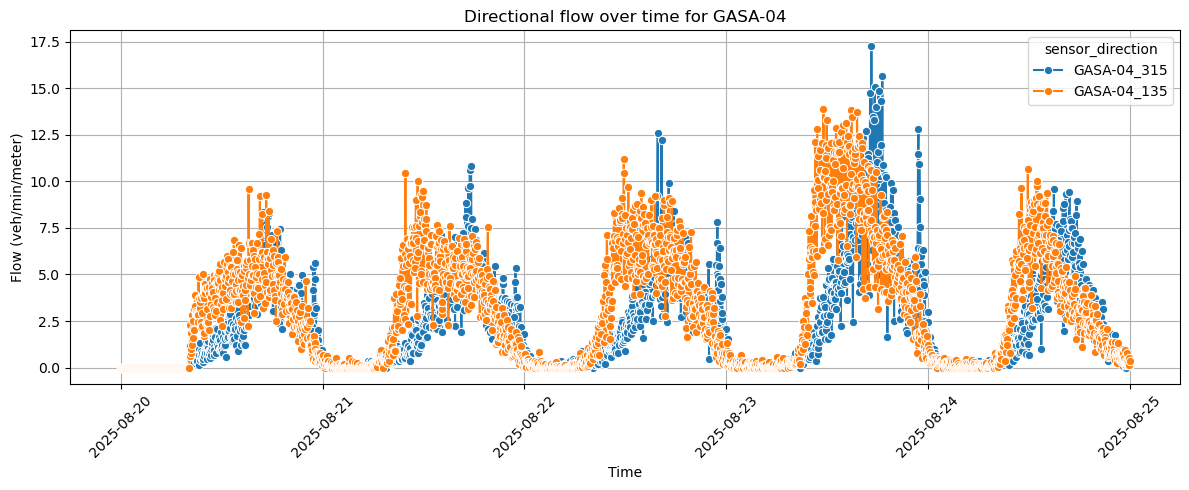

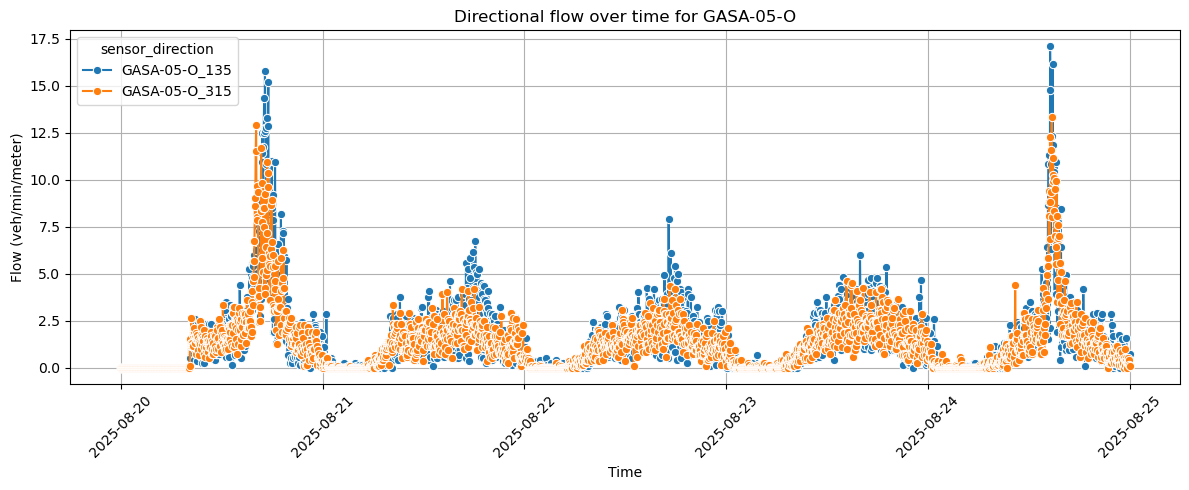

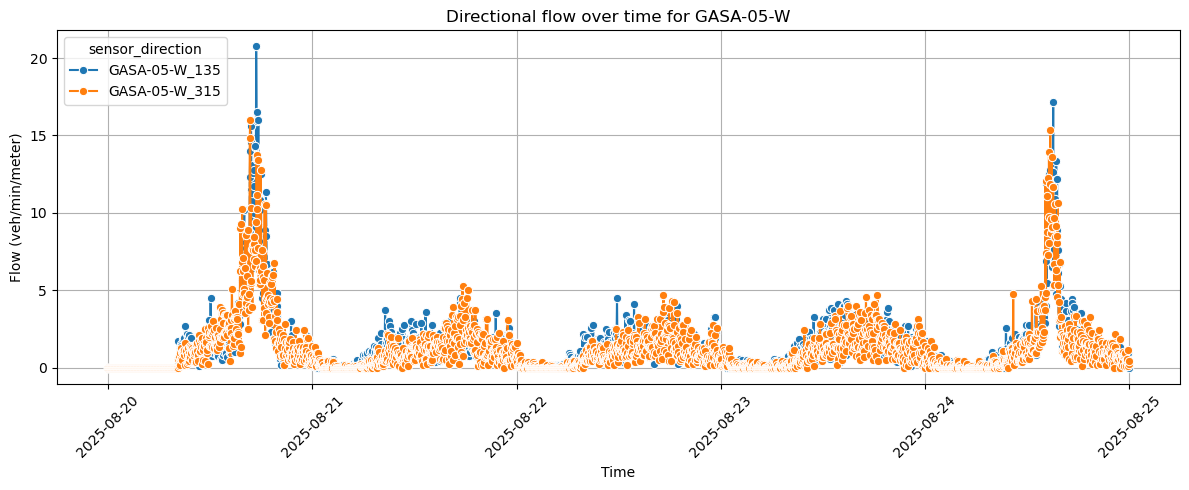

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure timestamp is datetime
df_long_sorted["timestamp"] = pd.to_datetime(df_long_sorted["timestamp"])
sensors = df_sensors["Objectummer"]
for sensor in sensors:
    df_plot = df_long_sorted[df_long_sorted["Objectummer"] == sensor]

    plt.figure(figsize=(12,5))
    sns.lineplot(
        data=df_plot,
        x="timestamp",
        y="flow",
        hue="sensor_direction",   # each direction gets its own line
        marker="o"
    )
    plt.title(f"Directional flow over time for {sensor}")
    plt.xlabel("Time")
    plt.ylabel("Flow (veh/min/meter)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


